<a href="https://colab.research.google.com/github/marinwitherspoon/Image_Description_Application/blob/Marin-Witherspoon/huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Logging into Hugging Face Notebook CLI

In [ ]:
pip install -U "huggingface_hub[cli]"

     ---------------------------------------- 0.0/67.7 kB ? eta -:--:--
     ---------------------------------------- 67.7/67.7 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from huggingface_hub import login
login()

In [ ]:
# Getting the required libraries
import json
from pathlib import Path
import os
import shutil
import pandas as pd
import random

In [ ]:
# Installing required libraries
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autotrain-advanced 0.6.18 requires werkzeug==2.3.6, but you have werkzeug 2.3.7 which is incompatible.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Preprocessing the Dataset for finetuning

Images

if below dataset structure is required. Use the code snippet below.

In [ ]:
def create_dataset_structure(source_folder, dest_folder, split_percent):
    """
    input: Takes the images folder where all our captions images are kept
    source_folder : folder where all the images are located
    dest_folder : where our output repository should be stored
    split_percent: amount of split required for training-testing
    output: Appropriately makes the file structure according to huggingface
            my_dataset_repository
                            ├── folder/train/image1.png
                            ├── folder/train/image2.png
                            ├── folder/train/image3.png
                            ├── folder/test/image4.png
                            └── folder/train/metadata.jsonl
    """
    ## creating testing and training folders in the destination folder
    train_folder = os.path.join(dest_folder, 'train')
    test_folder = os.path.join(dest_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok = True)

    # getting the list of images in source folder
    image_files = [f for f in os.listdir(source_folder) if f.endswith(('.jpg', '.jpeg','.png', '.gif'))]

    # Calculate the number of images for train and test based on split
    num_train = int(len(image_files)* 0.80)
    num_test =  int(len(image_files) * (1 - split_percent))

    # randomly shuffling images
    random.shuffle(image_files)

    # copying images to train folder
    for image_file in image_files[:num_train]:
        source_path = os.path.join(source_folder, image_file)
        dest_path = os.path.join(train_folder, image_file)
        shutil.copy(source_path, dest_path)

    # copying images to test folder
    for image_file in image_files[num_train:]:
        source_path = os.path.join(source_folder, image_file)
        dest_path = os.path.join(test_folder, image_file)
        shutil.copy(source_path, dest_path)


In [ ]:
source_folder = r"/Users/marinwitherspoon/Downloads/Images"
dest_folder = r"/Users/marinwitherspoon/Downloads/ImageFolder"
split_percent = 0.80
create_dataset_structure(source_folder, dest_folder, split_percent )

In [ ]:
#### checking if there are images lost while doing preprocessing
len(os.listdir(source_folder))

x = os.path.join(dest_folder, 'test')
y =os.path.join(dest_folder, 'train')
len(os.listdir(x)) + len(os.listdir(y))

7195

Captions -  4 captions are randomly dropped for each image.

In [ ]:
def hugging_face_model_format(source_folder, dest_folder):
    """
    input: Takes the processed captions file
    source_folder: This is where our processed captions will be stored
    dest_folder: This is where our images (train/test) are saved.

    output: Creates a output JSON File that is required by for the huggingface input model
           eg :  [{ "file_name" : "image.name" , "text" : "description of the text"} , ...
    """

    ## getting the processed captions
    with open(source_folder , 'r') as f:
        data = json.load(f)

    ## this model requires a  list of captions where each image is in {} format shown above in docstring
    random_captions = []
    for k , (image,caption) in data.items():
        random_captions.append({"file_name" : str(image) , "text": str(caption)})

    df = pd.DataFrame(random_captions)
    df_unique = df.sample(frac=1).drop_duplicates(subset='file_name').reset_index(drop=True)

    random_captions = df_unique.to_dict(orient='records')

    with open(os.path.join(dest_folder, 'metadata.jsonl'), 'w') as f:
        for item in random_captions:
            f.write(json.dumps(item) + '\n')
    return random_captions


source_folder  = r"C:\Users\smeet\Desktop\data science capstone\data_structure\data_captions_processed.json"
dest_folder = r"C:\Users\smeet\Desktop\data science capstone\imagefolder"
captions = hugging_face_model_format(source_folder, dest_folder)

In [ ]:
with open(source_folder, 'r') as f:
    data = json.load(f)

len(data)
len(captions)*5

40455

### Loading the Dataset


checking if our pre-processing images and captions worked or not

In [ ]:
from datasets import load_dataset


dataset_path = r"/Users/marinwitherspoon/Downloads/ImageFolder"
dataset = load_dataset(dataset_path)

Resolving data files:   0%|          | 0/5757 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1440 [00:00<?, ?it/s]

In [ ]:
dataset['train'], dataset['test']

(Dataset({
     features: ['image', 'text'],
     num_rows: 5756
 }),
 Dataset({
     features: ['image', 'text'],
     num_rows: 1439
 }))

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

Visualizing couple of samples

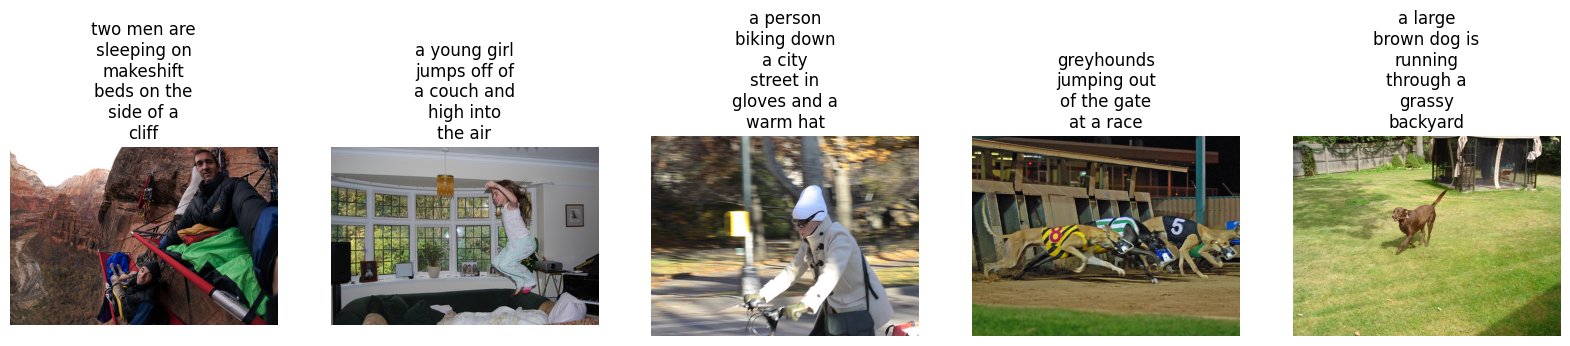

In [ ]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_dataset[i]["image"]) for i in range(10,15)]
sample_captions = [train_dataset[i]["text"] for i in range(10,15)]
plot_images(sample_images_to_visualize, sample_captions)

## PreProcess the Dataset

Since dataset has images and modalities, we need two pre-processing pipelines to process the images and the captions

In [ ]:
from transformers import AutoProcessor

basemodel = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(basemodel)

In [ ]:
# preprocessing the images and the text files
def preprocess(batch):
    images = [i for i in batch['image']]
    captions = [c for c in batch['text']]
    inputs = processor(images=images , text=captions, padding='max_length')
    inputs.update({"labels": inputs['input_ids']})
    return inputs

train_dataset.set_transform(preprocess)
test_dataset.set_transform(preprocess)

### Setting up the model for finetuning

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(basemodel)

c:\Users\smeet\AppData\Local\Programs\Python\Python311\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


#### Evaluate the model

Image captioning model are typically evaluated with rogue score and word error rate

In [ ]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install jiwer

Note: you may need to restart the kernel to use updated packages.


In [ ]:
## throws an error
## so downloaded wer.py online and saved in this project with wer/wer.py
# internet is slow --> so wait for 10 seconds before running this snippet again
import evaluate
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}


c:\Users\smeet\AppData\Local\Programs\Python\Python311\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


### Train

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = basemodel.split("/")[1]

training_args = TrainingArguments(
    output_dir= f"microsoft-git-base-flickr8k-trained",
    learning_rate=5e-5,
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

passing the dataset to the model

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

RepositoryNotFoundError: 404 Client Error. (Request ID: Root=1-65c3ce2c-05a579e06da8fbbd3f556314;291e2513-c173-4373-a51b-a45609d13afd)

Repository Not Found for url: https://huggingface.co/api/models/git-base.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.